In [29]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
# For reproducibility
np.random.seed(42)

# Parameters
n_units = 5200        # Total number of units
n_periods = 52       # Number of time periods
treatment_period = 27 # Time period when treatment is implemented

# Assign groups: 50 Treatment, 50 Control
groups = ['Treatment'] * (n_units // 2) + ['Control'] * (n_units // 2)

# Create a DataFrame with all combinations of units and periods
df = pd.DataFrame({
    'unit_id': np.repeat(np.arange(1, n_units + 1), n_periods),
    'period': np.tile(np.arange(1, n_periods + 1), n_units),
    'group': np.repeat(groups, n_periods)
})

# Assign dates based on period (assuming annual data for simplicity)
df['date'] = pd.to_datetime('2024-01-01') + pd.to_timedelta((df['period'] - 1) * 7, unit='d')

# Generate outcome variable
# Baseline outcome
df['outcome'] = 10 + df['period'] + np.random.normal(0, 5, size=len(df))

# Add treatment effect: only Treatment group after treatment_period
df['treatment'] = np.where((df['group'] == 'Treatment') & (df['period'] >= treatment_period), 1, 0)
df['outcome'] += df['treatment'] * 1  # Treatment increases outcome by 1 unit

# Display the first few rows
print("Sample Data:")
print(df.head(15))

Sample Data:
    unit_id  period      group       date    outcome  treatment
0         1       1  Treatment 2024-01-01  13.483571          0
1         1       2  Treatment 2024-01-08  11.308678          0
2         1       3  Treatment 2024-01-15  16.238443          0
3         1       4  Treatment 2024-01-22  21.615149          0
4         1       5  Treatment 2024-01-29  13.829233          0
5         1       6  Treatment 2024-02-05  14.829315          0
6         1       7  Treatment 2024-02-12  24.896064          0
7         1       8  Treatment 2024-02-19  21.837174          0
8         1       9  Treatment 2024-02-26  16.652628          0
9         1      10  Treatment 2024-03-04  22.712800          0
10        1      11  Treatment 2024-03-11  18.682912          0
11        1      12  Treatment 2024-03-18  19.671351          0
12        1      13  Treatment 2024-03-25  24.209811          0
13        1      14  Treatment 2024-04-01  14.433599          0
14        1      15  Treatm

In [92]:
# data exploration, including categorical variables
df.describe()

,unit_id,period,date,outcome,treatment
count,270400.000000,270400.000000,270400,270400.000000,270400.000000
mean,2600.500000,26.500000,2024-06-27 11:59:59.999999744,36.748820,0.250000
min,1.000000,1.000000,2024-01-01 00:00:00,-5.877896,0.000000
25%,1300.750000,13.750000,2024-03-30 06:00:00,23.475295,0.000000
50%,2600.500000,26.500000,2024-06-27 12:00:00,36.756649,0.000000
75%,3900.250000,39.250000,2024-09-24 18:00:00,50.030830,0.250000
max,5200.000000,52.000000,2024-12-23 00:00:00,80.027840,1.000000
std,1501.113448,15.008359,NaN,16.032714,0.433014


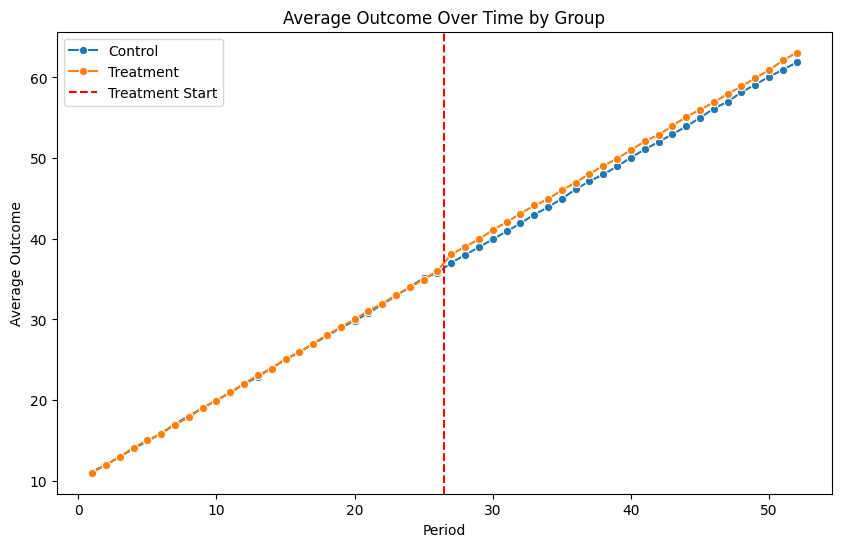

In [93]:
# Calculate average outcome by period and group
avg_outcome = df.groupby(['period', 'group'])['outcome'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_outcome, x='period', y='outcome', hue='group', marker='o')
plt.axvline(x=treatment_period - 0.5, color='red', linestyle='--', label='Treatment Start')
plt.title('Average Outcome Over Time by Group')
plt.xlabel('Period')
plt.ylabel('Average Outcome')
plt.legend()
plt.show()

In [94]:
import statsmodels.formula.api as smf

# Define placebo treatment period (one period before actual treatment)
placebo_period = treatment_period - 1

# Create placebo treatment indicator
df['placebo'] = np.where(df['period'] == placebo_period, 1, 0)

# Interaction term for placebo test
df['treated'] = np.where((df['group'] == 'Treatment'), 1, 0)
df['interaction_placebo'] = df['treated'] * df['placebo']

df.head(15)

,unit_id,period,group,date,outcome,treatment,placebo,treated,interaction_placebo
0,1,1,Treatment,2024-01-01,13.483571,0,0,1,0
1,1,2,Treatment,2024-01-08,11.308678,0,0,1,0
2,1,3,Treatment,2024-01-15,16.238443,0,0,1,0
3,1,4,Treatment,2024-01-22,21.615149,0,0,1,0
4,1,5,Treatment,2024-01-29,13.829233,0,0,1,0
5,1,6,Treatment,2024-02-05,14.829315,0,0,1,0
6,1,7,Treatment,2024-02-12,24.896064,0,0,1,0
7,1,8,Treatment,2024-02-19,21.837174,0,0,1,0
8,1,9,Treatment,2024-02-26,16.652628,0,0,1,0
9,1,10,Treatment,2024-03-04,22.712800,0,0,1,0


In [95]:
# Regression model for placebo test
# If the parallel trends assumption holds, 
# there should be no effect of the placebo treatment because it’s a fictitious treatment applied before the actual treatment. 
# Hence, the interaction term should not be significant.
model_placebo = smf.ols('outcome ~ treated + placebo + interaction_placebo + C(period)', data=df).fit()
print("\nPlacebo Test Results:")

# Interpretation:
# If the coefficient of 'interaction_placebo' is not statistically significant, it supports parallel trends.
print(model_placebo.pvalues)


Placebo Test Results:
Intercept               0.000000e+00
C(period)[T.2]          1.168994e-20
C(period)[T.3]          1.440452e-84
C(period)[T.4]         6.262308e-202
C(period)[T.5]          0.000000e+00
C(period)[T.6]          0.000000e+00
C(period)[T.7]          0.000000e+00
C(period)[T.8]          0.000000e+00
C(period)[T.9]          0.000000e+00
C(period)[T.10]         0.000000e+00
C(period)[T.11]         0.000000e+00
C(period)[T.12]         0.000000e+00
C(period)[T.13]         0.000000e+00
C(period)[T.14]         0.000000e+00
C(period)[T.15]         0.000000e+00
C(period)[T.16]         0.000000e+00
C(period)[T.17]         0.000000e+00
C(period)[T.18]         0.000000e+00
C(period)[T.19]         0.000000e+00
C(period)[T.20]         0.000000e+00
C(period)[T.21]         0.000000e+00
C(period)[T.22]         0.000000e+00
C(period)[T.23]         0.000000e+00
C(period)[T.24]         0.000000e+00
C(period)[T.25]         0.000000e+00
C(period)[T.26]         9.234018e-01
C(period)[T.27]

In [99]:
# Estimate the DiD effect using regression analysis
# Define Post treatment indicator
df['post'] = np.where(df['period'] >= treatment_period, 1, 0)

# Interaction term for DiD
df['interaction'] = df['treated'] = np.where(df['group'] == 'Treatment', 1, 0) * df['post']

# Fit DiD regression model
model_did = smf.ols('outcome ~ treated + post + interaction + C(period)', data=df).fit()
print("\nDifference-in-Differences Regression Results:")
print(model_did.params['interaction'])

# Interpretation:
# The coefficient of 'interaction' is the DiD estimator, representing the treatment effect.


Difference-in-Differences Regression Results:
-552105809807.8551
